In [124]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

### Import Libraries

In [125]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

### Define Paths and Labels

In [126]:
dataset_path = "brain-tumor-classification-mri"
data = {
    "train": "/kaggle/input/brain-tumor-classification-mri/Training",
    "test": "/kaggle/input/brain-tumor-classification-mri/Testing"
}
labels = ['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']

### Load Data Function

In [149]:
def load_data(data_path, labels, img_size=224):
    X, y = [], []
    if not os.path.exists(data_path):
        raise ValueError(f"Error: Path not found -> {data_path}")
    
    for label in labels:
        label_path = os.path.join(data_path, label)
        if not os.path.exists(label_path):
            print(f"Warning: Folder not found for label '{label}', skipping.")
            continue

        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: '{img_name}' could not be read, skipping.")
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (img_size, img_size))
                X.append(img)
                y.append(labels.index(label))
            except Exception as e:
                print(f"Warning: Error loading '{img_name}': {e}")
    
    return np.array(X), np.array(y)

### Load Data

In [128]:
X_train, y_train = load_data(data["train"], labels)
X_test, y_test = load_data(data["test"], labels)


### Normalize and One-Hot Encode

In [129]:
X_train, X_test = X_train.astype("float32") / 255.0, X_test.astype("float32") / 255.0
y_train, y_test = to_categorical(y_train, len(labels)), to_categorical(y_test, len(labels))

### Split Training and Validation Data

In [130]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Data Augmentation

In [131]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode="nearest"
)
datagen.fit(X_train)


### Build Model

In [132]:
model = Sequential([
    Input(shape=(224, 224, 3)), 
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

### Compile Model

In [141]:
# Adam optimizer, glioma_tumor sınıfı için daha yüksek precision sağladığı için tercih ediyorum.
# Bu optimizer ile modelin genel doğruluğu daha yüksek.
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Ancak, daha dengeli bir model istiyorsanız, RMSprop optimizer'ı da iyi sonuçlar verir, 
# fakat genel doğruluk ve precision biraz daha düşük kalabilir.
# model.compile(optimizer=RMSprop(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

### Convert to TensorFlow Dataset

In [142]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

### Train Model

In [143]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.9392 - loss: 0.1851 - val_accuracy: 0.9181 - val_loss: 0.2863
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9553 - loss: 0.1162 - val_accuracy: 0.8885 - val_loss: 0.3239
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9575 - loss: 0.1287 - val_accuracy: 0.9059 - val_loss: 0.3217
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9620 - loss: 0.0923 - val_accuracy: 0.9146 - val_loss: 0.3297
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9653 - loss: 0.0788 - val_accuracy: 0.9251 - val_loss: 0.2898
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9780 - loss: 0.0635 - val_accuracy: 0.9164 - val_loss: 0.3199
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9703 - loss: 0.1059 - val_accuracy: 0.9286 - val_loss: 0.2326
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9839 - loss: 0.0411 - val_accuracy: 0.9094 - v

### Evaluate Model


In [144]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8904 - loss: 1.3429
Test Loss: 4.1996
Test Accuracy: 0.7360


### Predictions

In [145]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


### Confusion Matrix

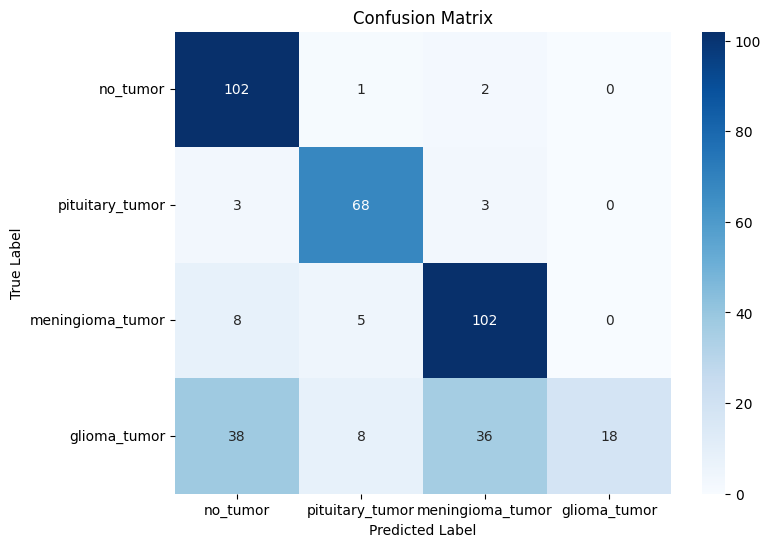

In [146]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


### Classification Report

In [148]:
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=labels))

Classification Report:
                  precision    recall  f1-score   support

        no_tumor       0.68      0.97      0.80       105
 pituitary_tumor       0.83      0.92      0.87        74
meningioma_tumor       0.71      0.89      0.79       115
    glioma_tumor       1.00      0.18      0.31       100

        accuracy                           0.74       394
       macro avg       0.80      0.74      0.69       394
    weighted avg       0.80      0.74      0.68       394

